# Day 7: Factor Models - Interview Questions & Weekly Review

## Learning Objectives
- Review all factor model concepts
- Practice technical interview questions
- Implement practical examples
- Solidify understanding for quant interviews

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pathlib import Path

# Configuration
DATA_DIR = Path('../datasets/raw_data')
TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Load data
df = pd.read_csv(DATA_DIR / 'combined_adjusted_close.csv', index_col='Date', parse_dates=True)
prices = df.ffill().dropna()
returns = prices.pct_change().dropna()

print("="*60)
print("WEEK 6 REVIEW: FACTOR MODELS")
print("="*60)

WEEK 6 REVIEW: FACTOR MODELS


## 1. Conceptual Questions

### Q1: What is the difference between CAPM and APT?

**Answer:**

| Aspect | CAPM | APT |
|--------|------|-----|
| Number of Factors | Single (Market) | Multiple |
| Derivation | Market equilibrium | No-arbitrage |
| Factor Specification | Market portfolio | Unspecified |
| Assumptions | Mean-variance preferences | Fewer restrictions |
| Testability | Requires market portfolio | More flexible |

### Q2: Explain the Fama-French factors

**Answer:**

**3-Factor Model:**
1. **MKT** (Market): Market excess return over risk-free rate
2. **SMB** (Small Minus Big): Small-cap vs large-cap return spread
3. **HML** (High Minus Low): Value vs growth return spread

**5-Factor Model adds:**
4. **RMW** (Robust Minus Weak): Profitable vs unprofitable firms
5. **CMA** (Conservative Minus Aggressive): Low vs high investment firms

### Q3: What is alpha in factor models?

**Answer:**
Alpha is the **excess return not explained by factor exposures**. It represents:
- Manager skill (if positive and significant)
- Mispricing or unexplained risk (alternative interpretation)

$$\alpha = R_p - [R_f + \sum_k \beta_k F_k]$$

## 2. Technical Implementation Questions

In [2]:
# Q4: Calculate beta from scratch
print("="*60)
print("Q4: Calculate Beta Two Ways")
print("="*60)

stock = 'AAPL'
market = 'SPY'

# Method 1: Covariance formula
cov = np.cov(returns[stock], returns[market])[0, 1]
var = np.var(returns[market])
beta_cov = cov / var

# Method 2: Regression
X = sm.add_constant(returns[market])
model = sm.OLS(returns[stock], X).fit()
beta_reg = model.params.iloc[1]

print(f"\nBeta for {stock}:")
print(f"  Covariance method: {beta_cov:.4f}")
print(f"  Regression method: {beta_reg:.4f}")
print(f"  Difference: {abs(beta_cov - beta_reg):.6f}")

Q4: Calculate Beta Two Ways

Beta for AAPL:
  Covariance method: 1.2220
  Regression method: 1.2213
  Difference: 0.000666



Q5: Rolling Beta Implementation


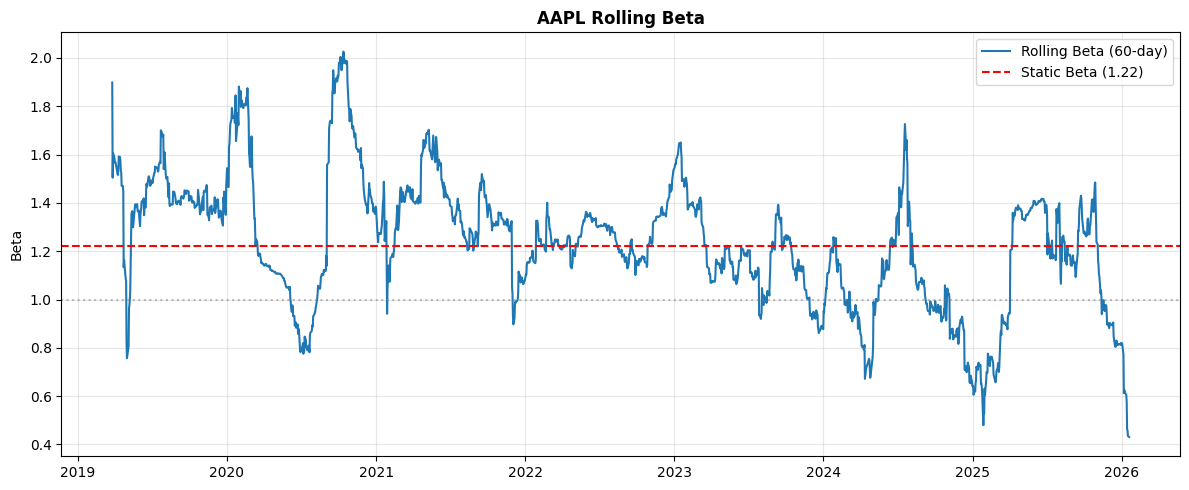

In [3]:
# Q5: Implement rolling beta
print("\n" + "="*60)
print("Q5: Rolling Beta Implementation")
print("="*60)

def rolling_beta(stock_returns, market_returns, window=60):
    """Calculate rolling beta."""
    rolling_cov = stock_returns.rolling(window).cov(market_returns)
    rolling_var = market_returns.rolling(window).var()
    return rolling_cov / rolling_var

rb = rolling_beta(returns['AAPL'], returns['SPY'])

plt.figure(figsize=(12, 5))
plt.plot(rb, label='Rolling Beta (60-day)')
plt.axhline(beta_reg, color='red', linestyle='--', label=f'Static Beta ({beta_reg:.2f})')
plt.axhline(1, color='gray', linestyle=':', alpha=0.5)
plt.title('AAPL Rolling Beta', fontweight='bold')
plt.ylabel('Beta')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [4]:
# Q6: Build a simple factor model
print("\n" + "="*60)
print("Q6: Build Custom Factor Model")
print("="*60)

# Construct factors
daily_rf = RISK_FREE_RATE / TRADING_DAYS
MKT = returns['SPY'] - daily_rf

# Simple momentum factor
mom_high = returns.rolling(60).mean().iloc[-1].nlargest(10).index.tolist()
mom_low = returns.rolling(60).mean().iloc[-1].nsmallest(10).index.tolist()
MOM = returns[[s for s in mom_high if s in returns.columns]].mean(axis=1) - \
      returns[[s for s in mom_low if s in returns.columns]].mean(axis=1)

# Run 2-factor regression
factors = pd.DataFrame({'MKT': MKT, 'MOM': MOM}).dropna()

test_stock = 'MSFT'
excess_ret = returns[test_stock] - daily_rf

aligned = pd.concat([excess_ret, factors], axis=1).dropna()
y = aligned.iloc[:, 0]
X = sm.add_constant(aligned[['MKT', 'MOM']])

model = sm.OLS(y, X).fit()

print(f"\n2-Factor Model for {test_stock}:")
print(f"  Alpha (annualized): {model.params['const'] * TRADING_DAYS:.2%}")
print(f"  Market Beta: {model.params['MKT']:.3f}")
print(f"  Momentum Beta: {model.params['MOM']:.3f}")
print(f"  R²: {model.rsquared:.4f}")


Q6: Build Custom Factor Model

2-Factor Model for MSFT:
  Alpha (annualized): 6.23%
  Market Beta: 1.165
  Momentum Beta: -0.045
  R²: 0.6504


## 3. Practical Interview Questions

### Q7: A portfolio has beta = 1.2, what does this mean?

**Answer:**
- The portfolio moves **1.2x the market** on average
- If market rises 1%, portfolio expected to rise 1.2%
- If market falls 1%, portfolio expected to fall 1.2%
- Portfolio has **higher systematic risk** than market
- In CAPM: $E[R] = R_f + 1.2 \times (E[R_m] - R_f)$

### Q8: How would you make a portfolio market-neutral?

**Answer:**
1. Calculate portfolio beta ($\beta_P$)
2. Determine hedge ratio = $\beta_P$
3. Short market index × hedge ratio
4. Hedged return: $R_{hedged} = R_P - \beta_P \times R_M$
5. Result: Portfolio with $\beta \approx 0$

In [5]:
# Q8: Demonstrate market neutralization
print("\n" + "="*60)
print("Q8: Market Neutralization Demo")
print("="*60)

# Create a portfolio
portfolio_stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
portfolio_stocks = [s for s in portfolio_stocks if s in returns.columns]
weights = np.ones(len(portfolio_stocks)) / len(portfolio_stocks)
portfolio_ret = (returns[portfolio_stocks] * weights).sum(axis=1)

# Calculate portfolio beta
cov = np.cov(portfolio_ret, returns['SPY'])[0, 1]
var = returns['SPY'].var()
port_beta = cov / var

# Hedge
hedged_ret = portfolio_ret - port_beta * returns['SPY']

# New beta
new_cov = np.cov(hedged_ret, returns['SPY'])[0, 1]
new_beta = new_cov / var

print(f"\nOriginal portfolio beta: {port_beta:.4f}")
print(f"Hedge ratio: {port_beta:.4f}")
print(f"Hedged portfolio beta: {new_beta:.6f}")


Q8: Market Neutralization Demo

Original portfolio beta: 1.1995
Hedge ratio: 1.1995
Hedged portfolio beta: 0.000000


### Q9: What are the limitations of factor models?

**Answer:**
1. **Factor selection**: Which factors to include?
2. **Factor stability**: Betas change over time
3. **Multicollinearity**: Correlated factors
4. **Data mining**: Factors may not persist
5. **Estimation error**: Statistical uncertainty
6. **Regime changes**: Different factor behavior in crises

### Q10: Explain factor investing vs market cap weighting

**Answer:**

| Market Cap Weighting | Factor Investing |
|---------------------|------------------|
| Weight by market cap | Weight by factor exposure |
| Passive, low turnover | Active, higher turnover |
| Tilted to large caps | Can target any factor |
| Market beta = 1 | Customizable exposures |
| Lower costs | Potentially higher returns |

## 4. Coding Challenge

In [6]:
# Challenge: Implement a complete factor model analysis
print("\n" + "="*60)
print("CODING CHALLENGE: Complete Factor Analysis")
print("="*60)

class FactorModel:
    """Complete factor model implementation."""
    
    def __init__(self, returns, market_ticker='SPY', rf=0.05):
        self.returns = returns
        self.market = returns[market_ticker]
        self.rf = rf / 252
        self.factors = None
        self.exposures = None
    
    def construct_factors(self):
        """Construct basic factors."""
        # Market
        MKT = self.market - self.rf
        
        # Momentum
        mom = self.returns.rolling(60).mean().iloc[-1]
        high = [s for s in mom.nlargest(15).index if s != 'SPY']
        low = [s for s in mom.nsmallest(15).index if s != 'SPY']
        MOM = self.returns[high].mean(axis=1) - self.returns[low].mean(axis=1)
        
        # Volatility
        vol = self.returns.std()
        low_vol = [s for s in vol.nsmallest(15).index if s != 'SPY']
        high_vol = [s for s in vol.nlargest(15).index if s != 'SPY']
        VOL = self.returns[low_vol].mean(axis=1) - self.returns[high_vol].mean(axis=1)
        
        self.factors = pd.DataFrame({'MKT': MKT, 'MOM': MOM, 'VOL': VOL}).dropna()
        return self.factors
    
    def calculate_exposures(self, stock):
        """Calculate factor exposures for a stock."""
        excess = self.returns[stock] - self.rf
        aligned = pd.concat([excess, self.factors], axis=1).dropna()
        y = aligned.iloc[:, 0]
        X = sm.add_constant(aligned[self.factors.columns])
        model = sm.OLS(y, X).fit()
        return model
    
    def analyze_portfolio(self, stocks, weights=None):
        """Analyze portfolio factor exposures."""
        if weights is None:
            weights = np.ones(len(stocks)) / len(stocks)
        
        port_ret = (self.returns[stocks] * weights).sum(axis=1)
        model = self.calculate_exposures_raw(port_ret)
        return model
    
    def calculate_exposures_raw(self, returns_series):
        """Calculate exposures for any return series."""
        excess = returns_series - self.rf
        aligned = pd.concat([excess, self.factors], axis=1).dropna()
        y = aligned.iloc[:, 0]
        X = sm.add_constant(aligned[self.factors.columns])
        return sm.OLS(y, X).fit()

# Use the model
fm = FactorModel(returns)
fm.construct_factors()

# Analyze a stock
model = fm.calculate_exposures('NVDA')

print(f"\nNVDA Factor Exposures:")
print(f"  Alpha: {model.params['const']*252:.2%}")
print(f"  MKT Beta: {model.params['MKT']:.3f}")
print(f"  MOM Beta: {model.params['MOM']:.3f}")
print(f"  VOL Beta: {model.params['VOL']:.3f}")
print(f"  R²: {model.rsquared:.4f}")


CODING CHALLENGE: Complete Factor Analysis

NVDA Factor Exposures:
  Alpha: 38.47%
  MKT Beta: 1.695
  MOM Beta: 0.056
  VOL Beta: -0.150
  R²: 0.4961


## 5. Week 6 Summary

### Topics Covered:
1. **Day 1**: CAPM - Single-factor model, beta calculation
2. **Day 2**: Fama-French 3-Factor - SMB, HML factors
3. **Day 3**: Fama-French 5-Factor - RMW, CMA additions
4. **Day 4**: APT - Multi-factor via PCA
5. **Day 5**: Factor Exposure Analysis - Portfolio decomposition
6. **Day 6**: Factor Portfolio Construction - Long-short strategies
7. **Day 7**: Interview Review

### Key Formulas:
$$\text{CAPM}: E[R_i] = R_f + \beta_i(E[R_m] - R_f)$$

$$\text{FF3}: R_i - R_f = \alpha + \beta_M MKT + \beta_S SMB + \beta_H HML + \epsilon$$

$$\text{Beta}: \beta = \frac{Cov(R_i, R_m)}{Var(R_m)}$$

### Next Week: Advanced Volatility Models
- GARCH variants
- Stochastic volatility
- Volatility forecasting